In [1]:
# Install libraries
#install.packages("pROC")
#install.packages("vctrs")
#install.packages("caret")
#install.packages("nnet")
#install.packages("ggplot2")
#install.packages("cowplot")
#install.packages("dplyr")
#install.packages("glmnet")

# Load libraries
library(pROC)
library(vctrs)
library(caret)
library(nnet)
library(ggplot2)
library(cowplot)
library(dplyr)
library(glmnet)

Warning message:
"package 'pROC' was built under R version 4.3.3"
Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Warning message:
"package 'vctrs' was built under R version 4.3.3"
Warning message:
"package 'caret' was built under R version 4.3.3"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Loading required package: lattice

Warning message:
"package 'nnet' was built under R version 4.3.3"
Warning message:
"package 'cowplot' was built under R version 4.3.3"
Warning message:
"package 'dplyr' was built under R version 4.3.3"

Attaching package: 'dplyr'


The following object is masked from 'package:vctrs':

    data_frame


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'glmnet' was

In [2]:
rm(list=ls()) #clears the workspace
data <- read.csv("SEIFA_RTT_LGA.csv")

# Remove rows with NAs in important percentile columns
cleaned_data <- data[complete.cases(data), ]

print(colnames(cleaned_data))

 [1] "lga_code"                  "IRSD.Decile"              
 [3] "IRSAD.Decile"              "IER.Decile"               
 [5] "IEO.Decile"                "Median.Income"            
 [7] "Lowest.Quartile.Income.."  "Highest.Quartile.Income.."
 [9] "Gini.Coefficient"          "Area..Km.2."              
[11] "Population"                "Population.Density"       
[13] "Population.Change"         "Population.Change.."      
[15] "Indigenous.Population"     "Indigenous.Population.."  
[17] "X5th.Percentile"           "X50th.Percentile"         
[19] "X95th.Percentile"          "X95th.5th.Ratio"          
[21] "major_city_distance"       "closest_capital_distance" 
[23] "own_capital_distance"      "Major.City"               
[25] "Inner.Regional"            "Outer.Regional"           
[27] "Remote"                    "Very.Remote"              
[29] "Division"                  "Previous.Party"           
[31] "Previous.Seat.Status"      "Successful.Party"         
[33] "Current.Seat.Statu

In [3]:
print('Number of rows in cleaned data:')
print(nrow(cleaned_data))

[1] "Number of rows in cleaned data:"
[1] 401


# BIG regression
### fit with all variables

   Remoteness_Area_1 Remoteness_Area_2   Mean_1   Mean_2      p_value
1         Major City    Inner Regional 2.627939 2.612283    0.7969307
2         Major City    Outer Regional 2.627939 2.251954 3.676235e-07
3         Major City            Remote 2.627939 2.241260  0.005570406
4         Major City       Very Remote 2.627939 2.164301 9.580539e-05
5     Inner Regional    Outer Regional 2.612283 2.251954 2.348145e-06
6     Inner Regional            Remote 2.612283 2.241260  0.008052161
7     Inner Regional       Very Remote 2.612283 2.164301 0.0001787961
8     Outer Regional            Remote 2.251954 2.241260    0.9382344
9     Outer Regional       Very Remote 2.251954 2.164301    0.4580679
10            Remote       Very Remote 2.241260 2.164301      0.63291
    Difference
1  -0.01565614
2  -0.37598508
3  -0.38667963
4  -0.46363879
5  -0.36032894
6  -0.37102350
7  -0.44798265
8  -0.01069456
9  -0.08765371
10 -0.07695916


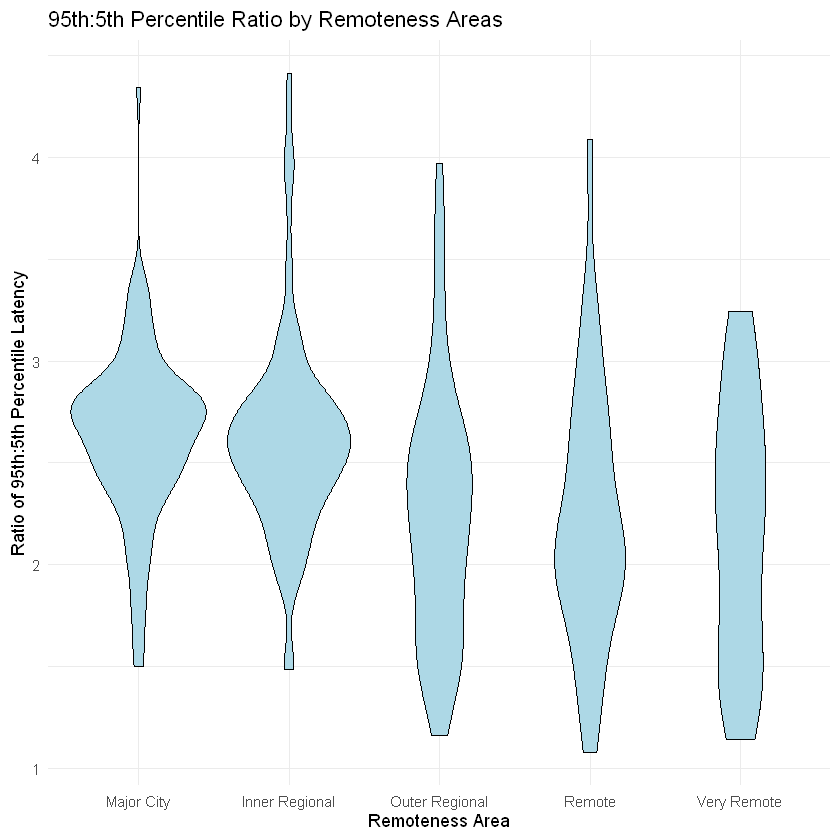

In [4]:
cleaned_data$Remoteness <- ifelse(cleaned_data$Major.City == 1, "Major City", ifelse(cleaned_data$Inner.Regional == 1, "Inner Regional", ifelse(cleaned_data$Outer.Regional == 1, "Outer Regional", ifelse(cleaned_data$Remote == 1, "Remote", "Very Remote"))))
cleaned_data$Remoteness <- factor(cleaned_data$Remoteness, levels = c("Major City", "Inner Regional", "Outer Regional", "Remote", "Very Remote"))

# Create the violin plot and assign it to variable 'p'
ggplot(cleaned_data, aes(x = Remoteness, y = X95th.5th.Ratio)) +
  geom_violin(fill = "lightblue", color = "black") +
  labs(x = "Remoteness Area", y = "Ratio of 95th:5th Percentile Latency",
       title = "95th:5th Percentile Ratio by Remoteness Areas") +
  theme_minimal()

# Create a data frame to store results of t-tests
results_table <- data.frame(Remoteness_Area_1 = character(), 
                             Remoteness_Area_2 = character(), 
                             Mean_1 = numeric(), 
                             Mean_2 = numeric(),
                             p_value = numeric(), 
                             Difference = numeric(), 
                             stringsAsFactors = FALSE)

# Perform t-tests between each pair of remoteness levels
remoteness_levels <- levels(cleaned_data$Remoteness)

for (i in 1:(length(remoteness_levels) - 1)) {
  for (j in (i + 1):length(remoteness_levels)) {
    test <- t.test(X95th.5th.Ratio ~ Remoteness, 
                   data = cleaned_data[cleaned_data$Remoteness %in% c(remoteness_levels[i], remoteness_levels[j]), ])
    
    # Calculate means
    mean_1 <- mean(cleaned_data$X95th.5th.Ratio[cleaned_data$Remoteness == remoteness_levels[i]], na.rm = TRUE)
    mean_2 <- mean(cleaned_data$X95th.5th.Ratio[cleaned_data$Remoteness == remoteness_levels[j]], na.rm = TRUE)
    
    # Add results to the data frame
    results_table <- rbind(results_table, 
                            data.frame(Remoteness_Area_1 = remoteness_levels[i], 
                                       Remoteness_Area_2 = remoteness_levels[j], 
                                       Mean_1 = mean_1, Mean_2 = mean_2,
                                       p_value = format(test$p.value, nsmall = 5),
                                       Difference = mean_2 - mean_1))
  }
}

# Print the results table
print(results_table)

## Begin Fitting

In [5]:
urban_data <- cleaned_data[(cleaned_data$Major.City == 1) | (cleaned_data$Inner.Regional == 1), ]
rural_data <- cleaned_data[(cleaned_data$Major.City == 0) & (cleaned_data$Inner.Regional == 0), ]

In [6]:
cor_matrix <- cor(cleaned_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile",
                            "IEO.Decile", "Median.Income",
                            "Lowest.Quartile.Income..",
                            "Highest.Quartile.Income..", "Gini.Coefficient",
                            "Area..Km.2.", "major_city_distance",
                            "closest_capital_distance", "own_capital_distance",
                            "Population", "Population.Density", 
                            "Population.Change", "Population.Change..",
                            "Indigenous.Population", "Indigenous.Population..",
                            "Swing", "Seat.Change", "is.Safe", "is.Marginal",
                            "Remained.Marginal")], use = "complete.obs")
#cor_matrix

#write.csv(cor_matrix, file = "correlation_matrix.csv", row.names = FALSE)

urban_cor_matrix <- cor(urban_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile",
                            "IEO.Decile", "Median.Income",
                            "Lowest.Quartile.Income..",
                            "Highest.Quartile.Income..", "Gini.Coefficient",
                            "Area..Km.2.", "major_city_distance",
                            "closest_capital_distance", "own_capital_distance",
                            "Population", "Population.Density", 
                            "Population.Change", "Population.Change..",
                            "Indigenous.Population", "Indigenous.Population..",
                            "Swing", "Seat.Change", "is.Safe", "is.Marginal",
                            "Remained.Marginal")], use = "complete.obs")

#write.csv(urban_cor_matrix, file = "urban_correlation_matrix.csv", row.names = FALSE)

# rural correlation matrix
rural_cor_matrix <- cor(rural_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile",
                            "IEO.Decile", "Median.Income",
                            "Lowest.Quartile.Income..",
                            "Highest.Quartile.Income..", "Gini.Coefficient",
                            "Area..Km.2.", "major_city_distance",
                            "closest_capital_distance", "own_capital_distance",
                            "Population", "Population.Density", 
                            "Population.Change", "Population.Change..",
                            "Indigenous.Population", "Indigenous.Population..",
                            "Swing", "Seat.Change", "is.Safe", "is.Marginal",
                            "Remained.Marginal")], use = "complete.obs")

#write.csv(rural_cor_matrix, file = "rural_correlation_matrix.csv", row.names = FALSE)


Warning message in cor(rural_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile", :
"the standard deviation is zero"


In [7]:
# Create scaled (normalised) versions of the combined data
cleaned_scaled <- as.data.frame(scale(cleaned_data[, c('IRSAD.Decile', 'Median.Income', 'Gini.Coefficient', 'Area..Km.2.', 
                                                       'closest_capital_distance', 'Population', 'Population.Density', 
                                                       'Population.Change..','Indigenous.Population..','Swing', 'Seat.Change',
                                                       'is.Safe', 'is.Marginal', 'Remained.Marginal')]))

# Add the unscaled percentile columns back in (filtering by the same rows)
cleaned_scaled$X5th.Percentile <- cleaned_data$X5th.Percentile
cleaned_scaled$X50th.Percentile <- cleaned_data$X50th.Percentile
cleaned_scaled$X95th.Percentile <- cleaned_data$X95th.Percentile
cleaned_scaled$X95th.5th.Ratio <- cleaned_data$X95th.5th.Ratio

# Repeat for urban and rural data
urban_scaled <- as.data.frame(scale(urban_data[, c('IRSAD.Decile', 'Median.Income', 'Gini.Coefficient', 'Area..Km.2.', 
                                                       'closest_capital_distance', 'Population', 'Population.Density', 
                                                       'Population.Change..','Indigenous.Population..','Swing', 'Seat.Change',
                                                       'is.Safe', 'is.Marginal', 'Remained.Marginal')]))

urban_scaled$X5th.Percentile <- urban_data$X5th.Percentile
urban_scaled$X50th.Percentile <- urban_data$X50th.Percentile
urban_scaled$X95th.Percentile <- urban_data$X95th.Percentile
urban_scaled$X95th.5th.Ratio <- urban_data$X95th.5th.Ratio

rural_scaled <- as.data.frame(scale(rural_data[, c('IRSAD.Decile', 'Median.Income', 'Gini.Coefficient', 'Area..Km.2.', 
                                                       'closest_capital_distance', 'Population', 'Population.Density', 
                                                       'Population.Change..','Indigenous.Population..','Swing',
                                                       'is.Safe', 'is.Marginal', 'Remained.Marginal')]))

rural_scaled$X5th.Percentile <- rural_data$X5th.Percentile
rural_scaled$X50th.Percentile <- rural_data$X50th.Percentile
rural_scaled$X95th.Percentile <- rural_data$X95th.Percentile
rural_scaled$X95th.5th.Ratio <- rural_data$X95th.5th.Ratio

print(sum(complete.cases(cleaned_scaled)))
print(sum(complete.cases(urban_scaled)))
print(sum(complete.cases(rural_scaled)))


[1] 401
[1] 222
[1] 179


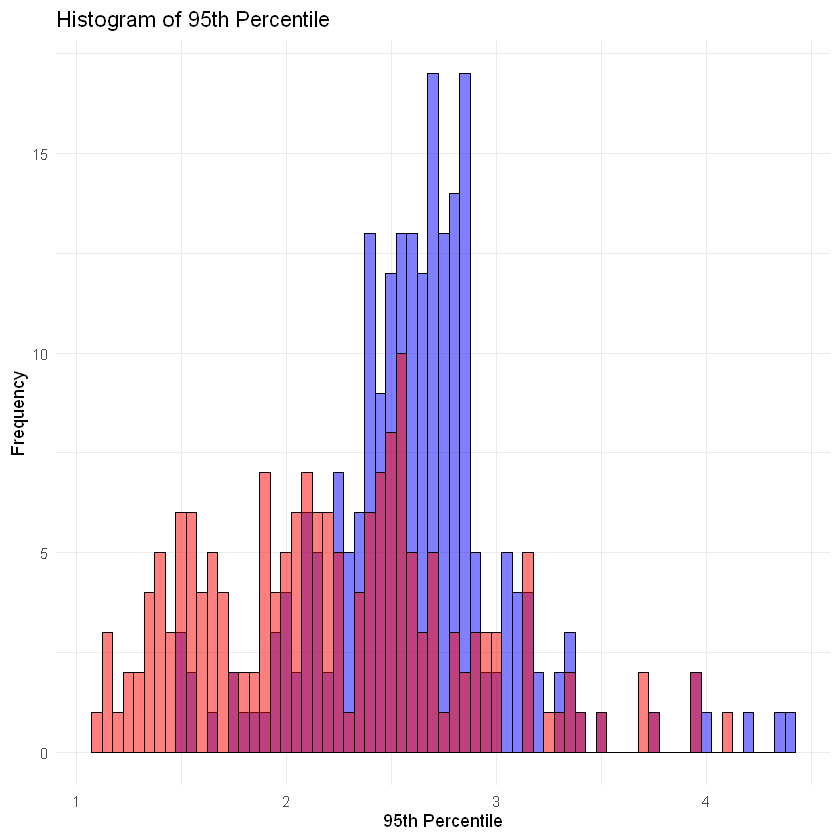

In [12]:
# First histogram for urban data
p <- ggplot(urban_scaled, aes(x = X95th.5th.Ratio)) +
  geom_histogram(binwidth = 0.05, fill = "blue", color = "black", alpha = 0.5) +
  labs(title = "Histogram of 95th Percentile", x = "95th Percentile", y = "Frequency") +
  theme_minimal()

# Add the rural histogram
p + geom_histogram(data = rural_scaled, aes(x = X95th.5th.Ratio), 
                   binwidth = 0.05, fill = "red", color = "black", alpha = 0.5)

In [13]:
# Keep only rows where X5th.Percentile is less than 500
cleaned_scaled <- cleaned_scaled[cleaned_scaled$X5th.Percentile < 750, ]
urban_scaled <- urban_scaled[urban_scaled$X5th.Percentile < 750, ]
rural_scaled <- rural_scaled[rural_scaled$X5th.Percentile < 750, ]

# Keep only rows where X50.Percentile is less than 500
cleaned_scaled <- cleaned_scaled[cleaned_scaled$X50th.Percentile < 750, ]
urban_scaled <- urban_scaled[urban_scaled$X50th.Percentile < 750, ]
rural_scaled <- rural_scaled[rural_scaled$X50th.Percentile < 750, ]

# Keep only rows where X95.Percentile is less than 750
cleaned_scaled <- cleaned_scaled[cleaned_scaled$X95th.Percentile < 750, ]
urban_scaled <- urban_scaled[urban_scaled$X95th.Percentile < 750, ]
rural_scaled <- rural_scaled[rural_scaled$X95th.Percentile < 750, ]

In [17]:
fit <- lm(cleaned_scaled$X95th.Percentile ~ IRSAD.Decile +
            Gini.Coefficient + Area..Km.2. +  
            closest_capital_distance + Population + Population.Density + 
            + Population.Change.. + Indigenous.Population.. +
            Swing + is.Safe + is.Marginal +
            Remained.Marginal, data = cleaned_scaled)

## AIC

In [18]:
# Fit the model with stepwise AIC selection
fit_aic <- step(fit)
summary(fit_aic)

Start:  AIC=3329.85
cleaned_scaled$X95th.Percentile ~ IRSAD.Decile + Gini.Coefficient + 
    Area..Km.2. + closest_capital_distance + Population + Population.Density + 
    +Population.Change.. + Indigenous.Population.. + Swing + 
    is.Safe + is.Marginal + Remained.Marginal

                           Df Sum of Sq     RSS    AIC
- Swing                     1        44 1759559 3327.9
- Gini.Coefficient          1       911 1760425 3328.1
- Population                1      1618 1761132 3328.2
- is.Marginal               1      2603 1762118 3328.4
- Remained.Marginal         1      3520 1763035 3328.6
- Area..Km.2.               1      5166 1764681 3329.0
- IRSAD.Decile              1      5591 1765106 3329.1
- Population.Density        1      7213 1766728 3329.5
- is.Safe                   1      8362 1767876 3329.7
<none>                                  1759515 3329.8
- closest_capital_distance  1     15359 1774874 3331.3
- Population.Change..       1     17781 1777296 3331.8
- Indig


Call:
lm(formula = cleaned_scaled$X95th.Percentile ~ closest_capital_distance + 
    Population.Change.. + Indigenous.Population.. + is.Safe, 
    data = cleaned_scaled)

Residuals:
     Min       1Q   Median       3Q      Max 
-217.729  -30.597   -3.325   24.343  289.897 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               444.628      3.417 130.115  < 2e-16 ***
closest_capital_distance   -6.001      4.171  -1.439 0.150993    
Population.Change..         8.309      3.503   2.372 0.018175 *  
Indigenous.Population..   -14.717      4.190  -3.513 0.000496 ***
is.Safe                    -6.200      3.474  -1.785 0.075047 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 67.74 on 388 degrees of freedom
Multiple R-squared:  0.1051,	Adjusted R-squared:  0.09591 
F-statistic:  11.4 on 4 and 388 DF,  p-value: 9.35e-09


## BIC

In [19]:
fit_bic <- step(fit, direction = "both", k = log(nrow(cleaned_data)))
summary(fit_bic)

Start:  AIC=3381.77
cleaned_scaled$X95th.Percentile ~ IRSAD.Decile + Gini.Coefficient + 
    Area..Km.2. + closest_capital_distance + Population + Population.Density + 
    +Population.Change.. + Indigenous.Population.. + Swing + 
    is.Safe + is.Marginal + Remained.Marginal

                           Df Sum of Sq     RSS    AIC
- Swing                     1        44 1759559 3375.8
- Gini.Coefficient          1       911 1760425 3376.0
- Population                1      1618 1761132 3376.1
- is.Marginal               1      2603 1762118 3376.4
- Remained.Marginal         1      3520 1763035 3376.6
- Area..Km.2.               1      5166 1764681 3376.9
- IRSAD.Decile              1      5591 1765106 3377.0
- Population.Density        1      7213 1766728 3377.4
- is.Safe                   1      8362 1767876 3377.6
- closest_capital_distance  1     15359 1774874 3379.2
- Population.Change..       1     17781 1777296 3379.7
<none>                                  1759515 3381.8
- Indig


Call:
lm(formula = cleaned_scaled$X95th.Percentile ~ Population.Change.. + 
    Indigenous.Population.., data = cleaned_scaled)

Residuals:
     Min       1Q   Median       3Q      Max 
-224.909  -33.896   -1.088   21.488  295.093 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)              444.677      3.434 129.504  < 2e-16 ***
Population.Change..        9.480      3.483   2.722  0.00678 ** 
Indigenous.Population..  -17.553      3.506  -5.006 8.43e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 68.07 on 390 degrees of freedom
Multiple R-squared:  0.09177,	Adjusted R-squared:  0.08711 
F-statistic:  19.7 on 2 and 390 DF,  p-value: 7.053e-09


In [ ]:
summary(cleaned_scaled$Area..Km.2.)
summary(urban_scaled$Area..Km.2.)
summary(rural_scaled$Area..Km.2.)

## Ridge Regression

In [ ]:
cv_alpha <- function(x, y, nfolds = 5) {
  alphas <- seq(0, 1, by = 0.1)
  cv_errors <- numeric(length(alphas))
  
  for (i in seq_along(alphas)) {
    fit <- cv.glmnet(x, y, alpha = alphas[i], nfolds = nfolds)
    cv_errors[i] <- min(fit$cvm)
  }
  
  best_alpha <- alphas[which.min(cv_errors)]
  return(best_alpha)}

x <- model.matrix(rural_scaled$X95th.Percentile ~ IRSAD.Decile +
            Median.Income + Gini.Coefficient + Area..Km.2. +
            closest_capital_distance + Population + Population.Density +
            Population.Change.. + Indigenous.Population.. +
            Swing +
            # Seat.Change +
            is.Safe + is.Marginal +
            Remained.Marginal, data = rural_scaled)

y <- rural_scaled$X95th.Percentile

# Fit Lasso regression model (alpha = 1 for Lasso)
cv_model_best <- cv.glmnet(x, y, alpha = 0)

# Plot the cross-validation curve
par(bg= "white")
plot(cv_model_best)

# Get the best lambda
best_lambda <- cv_model_best$lambda.min
print(best_lambda)

# Fit the final model with the best alpha and lambda
final_model_best <- glmnet(x, y, alpha = 0, lambda = best_lambda)
selected_vars <- rownames(coef(final_model_best))[-1][coef(final_model_best)[-1, 1] != 0]

# Create a formula for the selected variables
formula <- as.formula(paste("X95th.Percentile ~", paste(selected_vars, collapse = " + ")))
ridge_model <- glm(formula, data = rural_scaled)
summary(ridge_model)
options(repr.plot.width = 10, repr.plot.height = 6)
plot(predict(ridge_model, rural_scaled), rural_scaled$X95th.Percentile, 
            main="Prediction performance of Ridge model", 
            ylab= "Recorded", xlab="Predicted")
plot(ridge_model$fitted.values, resid(ridge_model), 
     main = "Residuals vs Predicted", 
     xlab = "Predicted", 
     ylab = "Residuals")
abline(h = 0, col = "red")

## Lasso Regression

In [ ]:
cv_alpha <- function(x, y, nfolds = 5) {
  alphas <- seq(0, 1, by = 0.1)
  cv_errors <- numeric(length(alphas))
  
  for (i in seq_along(alphas)) {
    fit <- cv.glmnet(x, y, alpha = alphas[i], nfolds = nfolds)
    cv_errors[i] <- min(fit$cvm)
  }
  
  best_alpha <- alphas[which.min(cv_errors)]
  return(best_alpha)}

x <- model.matrix(cleaned_scaled$X95th.Percentile ~ IRSAD.Decile +
            Median.Income + Gini.Coefficient + Area..Km.2. +
            closest_capital_distance + Population + Population.Density +
            Population.Change.. + Indigenous.Population.. +
            Swing +
            # Seat.Change +
            is.Safe + is.Marginal +
            Remained.Marginal, data = cleaned_scaled)

y <- cleaned_scaled$X95th.Percentile

# Fit Lasso regression model (alpha = 1 for Lasso)
cv_model_best <- cv.glmnet(x, y, alpha = 1)

# Plot the cross-validation curve
par(bg= "white")
plot(cv_model_best)

# Get the best lambda
best_lambda <- cv_model_best$lambda.min
print(best_lambda)

# Fit the final model with the best alpha and lambda
final_model_best <- glmnet(x, y, alpha = 1, lambda = best_lambda)
selected_vars <- rownames(coef(final_model_best))[-1][coef(final_model_best)[-1, 1] != 0]
if (length(selected_vars) == 0) {print('No variables selected')}

# Create a formula for the selected variables
formula <- as.formula(paste("X95th.Percentile ~", paste(selected_vars, collapse = " + ")))
lasso_model <- glm(formula, data = cleaned_scaled)
summary(lasso_model)
options(repr.plot.width = 10, repr.plot.height = 6)
plot(predict(lasso_model, cleaned_scaled), cleaned_scaled$X95th.Percentile, 
            main="Prediction performance of Ridge model", 
            ylab= "Recorded", xlab="Predicted")
plot(lasso_model$fitted.values, resid(lasso_model), 
     main = "Residuals vs Predicted", 
     xlab = "Predicted", 
     ylab = "Residuals")
abline(h = 0, col = "red")

## Elastic Net Regression

In [ ]:
cv_alpha <- function(x, y, nfolds = 5) {
  alphas <- seq(0, 1, by = 0.1)
  cv_errors <- numeric(length(alphas))
  
  for (i in seq_along(alphas)) {
    fit <- cv.glmnet(x, y, alpha = alphas[i], nfolds = nfolds)
    cv_errors[i] <- min(fit$cvm)
  }
  
  best_alpha <- alphas[which.min(cv_errors)]
  return(best_alpha)}

x <- model.matrix(cleaned_scaled$X95th.Percentile ~ IRSAD.Decile +
            Median.Income + Gini.Coefficient + Area..Km.2. +
            closest_capital_distance + Population + Population.Density +
            Population.Change.. + Indigenous.Population.. +
            Swing +
            # Seat.Change +
            is.Safe + is.Marginal +
            Remained.Marginal, data = cleaned_scaled)

y <- cleaned_scaled$X95th.Percentile

# Find the best alpha
best_alpha <- cv_alpha(x, y)
cat("Best alpha:", best_alpha, "\n")

# Fit Lasso regression model (alpha = 1 for Lasso)
cv_model_best <- cv.glmnet(x, y, alpha = best_alpha)

# Plot the cross-validation curve
par(bg= "white")
plot(cv_model_best)

# Get the best lambda
best_lambda <- cv_model_best$lambda.min
print(best_lambda)

# Fit the final model with the best alpha and lambda
final_model_best <- glmnet(x, y, alpha = best_alpha, lambda = best_lambda)
selected_vars <- rownames(coef(final_model_best))[-1][coef(final_model_best)[-1, 1] != 0]
if (length(selected_vars) == 0) {print('No variables selected')}

# Create a formula for the selected variables
formula <- as.formula(paste("X95th.Percentile ~", paste(selected_vars, collapse = " + ")))
elastic_model <- glm(formula, data = cleaned_scaled)
summary(ridge_model)
options(repr.plot.width = 10, repr.plot.height = 6)
plot(predict(elastic_model, cleaned_scaled), cleaned_scaled$X95th.Percentile, 
            main="Prediction performance of Ridge model", 
            ylab= "Recorded", xlab="Predicted")
plot(elastic_model$fitted.values, resid(elastic_model), 
     main = "Residuals vs Predicted", 
     xlab = "Predicted", 
     ylab = "Residuals")
abline(h = 0, col = "red")

## idk, something else now

In [ ]:
ggplot(cleaned_scaled, aes(x = Median.Income, y = X95th.Percentile)) +
  geom_point(color = "blue") +
  labs(title = "Independent Variable vs Target Outcome", x = "Independent Variable", y = "Target Outcome") +
  theme_minimal()

In [ ]:
# Generate predicted values
cleaned_scaled$predicted_values <- predict(ridge_model, newdata = cleaned_scaled)

# Create a new column to classify urban and rural
cleaned_data$category <- ifelse(cleaned_data$Major.City == 1 | cleaned_data$Inner.Regional == 1, "Urban", "Rural")

# Create the plot
ggplot(cleaned_scaled, aes(x = predicted_values, y = X5th.Percentile, color = category)) +
  geom_point() +  # Actual data points
  geom_smooth(method = "lm", color = "blue", se = FALSE) +  # Linear regression line
  scale_color_manual(values = c("Urban" = "blue", "Rural" = "red")) +  # Set colors for categories
  labs(title = "95th Percentile", 
       x = "Fitted 95th Percentile [ms]", 
       y = "Actual 95th Percentile [ms]", 
       color = "Category") +  # Legend title
  theme_minimal() +
  xlim(min(cleaned_data$predicted_values), max(cleaned_data$predicted_values)) +  # Set x limits
  ylim(min(cleaned_data$X5th.Percentile), max(cleaned_data$X5th.Percentile))  # Set y limits


## All Hours vs Busy Hours

In [ ]:
# Create a data frame to store results
results <- data.frame(Variable = character(),
                      Comparison = character(),
                      p.value = numeric(),
                      stringsAsFactors = FALSE)

# List of pairs to compare
pairs <- list(
  c("X5th.Percentile", "Busy.5th.Percentile"),
  c("X50th.Percentile", "Busy.50th.Percentile"),
  c("X95th.Percentile", "Busy.95th.Percentile"),
  c("X95th.5th.Ratio", "Busy.95th.5th.Ratio")
)
pairs <- list(
  c("X5th.Percentile", "X5th.Percentile"),
  c("X50th.Percentile", "X50th.Percentile"),
  c("X95th.Percentile", "X95th.Percentile"),
  c("X95th.5th.Ratio", "X95th.5th.Ratio")
)

# Perform t-tests for each pair
for (pair in pairs) {
  var1 <- pair[1]
  var2 <- pair[2]
  
  # Perform t-test
  test <- t.test(urban_data[[var1]], rural_data[[var2]])
  
  # Store results
  results <- rbind(results, data.frame(Variable = var1,
                                        Comparison = var2,
                                        p.value = test$p.value))
}

# View results
print(results)


In [ ]:
summary(cleaned_data$X95th.5th.Ratio)
summary(cleaned_data$Busy.95th.5th.Ratio)

In [ ]:
# Set background color to white and text color to black
par(bg = "white", col.axis = "black", col.lab = "black", col.main = "black")

# Calculate the minimum and maximum from both datasets
minimum <- min(c(urban_data$X95th.5th.Ratio, rural_data$X95th.5th.Ratio))
maximum <- max(c(urban_data$X95th.5th.Ratio, rural_data$X95th.5th.Ratio))

# Define the breaks for intervals of 5
bin_size <- 0.1
breaks <- seq(floor(minimum / bin_size) * bin_size, ceiling(maximum / bin_size) * bin_size, by = bin_size)

# Create the histogram for urban data
hist(urban_data$X95th.5th.Ratio,
     breaks = breaks,
     main = "Frequency Histogram of 95th:5th Percentile Ratio (Urban vs. Rural)",
     xlab = "95th:5th Percentile Ratio Values",
     ylab = "Frequency",
     col = rgb(0, 0, 1, 0.5),  # Blue with transparency
     border = "black",
     xlim = c(minimum, maximum),  # Ensure x-axis covers the full range
     ylim = c(0, max(table(cut(urban_data$X95th.5th.Ratio, breaks)), 
                           table(cut(rural_data$X95th.5th.Ratio, breaks)))))  # Adjust y-axis limit

# Overlay the histogram for rural data
hist(rural_data$X95th.5th.Ratio,
     breaks = breaks,
     col = rgb(1, 0, 0, 0.5),  # Red with transparency
     border = "black",
     add = TRUE)  # Overlay this histogram


In [ ]:
apply(cleaned_data, 2, var)
nzv <- nearZeroVar(data, saveMetrics = TRUE)
nzv[nzv$zeroVar == TRUE, ]

In [ ]:
pca_result <- prcomp(cleaned_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile",
                            "IEO.Decile", "Population", "Gini.Coefficient",
                            "Population.Change", "X..Population.Change", 
                            "Area..Km.2.", "Population.Density", 
                            "Indigenous.Population", 
                            "X..Indigenous.Population")], 
                            scale. = TRUE)  # Standardize data before PCA

# View the PCA summary to see the proportion of variance
summary(pca_result)

# Use the first few principal components that explain the most variance
pca_components <- pca_result$x[, 1:10]  # Replace 1:5 with desired slice

# Fit a new model using the principal components
pca_model <- lm(X95th.5th.Ratio ~ pca_components, data = cleaned_data)

# View the summary of the new model
summary(pca_model)

### visualise against certain significant variables

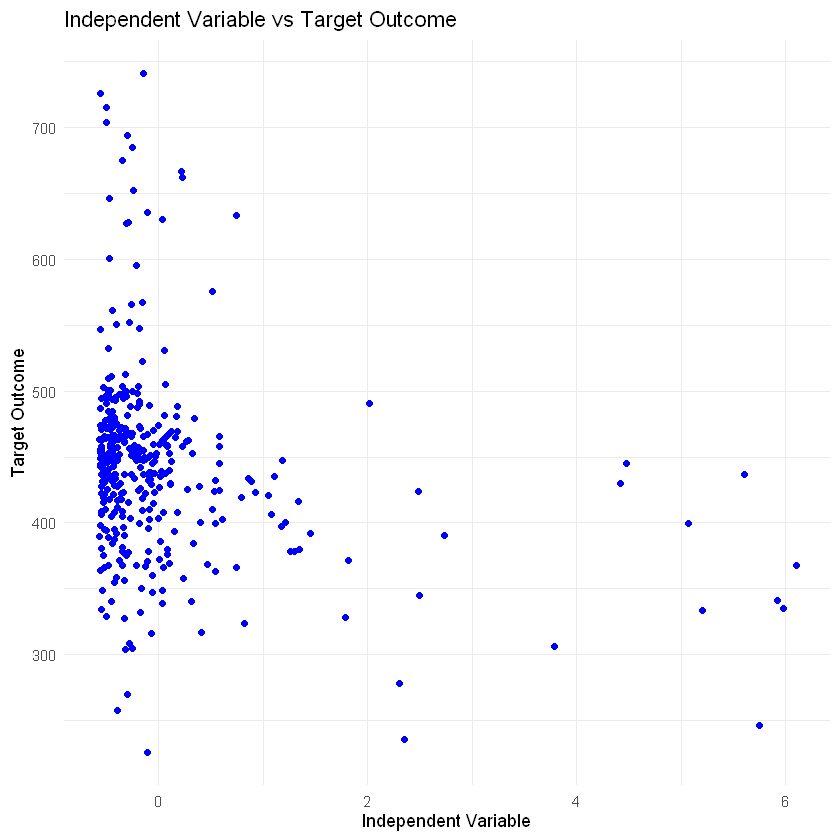

In [20]:
ggplot(cleaned_scaled, aes(x = Indigenous.Population.., y = X95th.Percentile)) +
  geom_point(color = "blue") +
  labs(title = "Independent Variable vs Target Outcome", x = "Independent Variable", y = "Target Outcome") +
  theme_minimal()

In [ ]:
summary(cleaned_scaled$Area..Km.2.)

### perform and plot the predictions

In [ ]:
par(bg = "white")
predictions <- predict(fit, cleaned_data)
plot(predict(fit, cleaned_data), cleaned_data$X95th.Percentile)
#calculate mean squared error
mean((predictions - target_variable)^2)